In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [13]:

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D
        

        # y = OBSERVATIONS (D) BY x = STATES (L)

        # Set start state transitions to be A_start.
        probs[0] = self.A_start
        for t in range(1, M+1):
            for o_curr in range(num_states):
                # For first state after the state state, only multiply the previous
                # probability by emission probability.
                if t == 1:
                    checkVal = np.array(probs[t-1]) * self.O[o_curr][x[t-1]]
                    # Set the maximum probability to be the value at the next probs[i, j] and 
                    # add the max probability sequence to seqs.
                    probs[t][o_curr] = max(checkVal)
                    add = []
                    for j in range(num_states):
                        add.append(str(j))
                    seqs[t] = add

                else:
                    # For other states, multiply the previous
                    # max probability by the emission and transition probability.
                    checkVal = np.multiply(probs[t-1], np.transpose(self.A)[o_curr]) * self.O[o_curr][x[t-1]]
                    max_index = np.argmax(checkVal)
                    # Set the maximum probability to be the value at the next probs[i, j] and 
                    # add the max probability sequence to seqs.
                    probs[t][o_curr] = max(checkVal)
                    add = seqs[t-1][max_index] + str(o_curr)
                    seqs[t][o_curr] = add

        # Get the maximum probability and max probability sequence. 
        max_prob_i = np.argmax(probs[M])
        max_seq = seqs[M][max_prob_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D
        alphas[0] = self.A_start

        for t in range(1, M+1):
            for o_curr in range(num_states):
                # For each state, multiply the previous
                # max probability by the emission and transition probability, set alphas
                # to be the sum of probabilities.
                if t == 1:
                    checkVal = np.array(alphas[t-1]) * self.O[o_curr][x[t-1]] * self.A_start[0]
                    alphas[t][o_curr] = sum(checkVal)

                else:
                    checkVal = np.multiply(alphas[t-1], np.transpose(self.A)[o_curr]) * self.O[o_curr][x[t-1]]
                    max_index = np.argmax(checkVal)
                    alphas[t][o_curr] = sum(checkVal)

        return alphas



    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D

        # Initialize end probabilities to be 1. 
        for i in range(num_states):
            betas[M][i] = 1

        t = M-1

        while t >= 0:
            for o_curr in range(num_states):
                # Take the sum of the previous probability times the 
                # transition and emission probabilities.
                checkVal = 0
                for i in range(len(self.A)):
                    checkVal += (betas[t+1][i]* self.A[o_curr][i]) * self.O[i][x[t]]   
                betas[t][o_curr] = checkVal
            t -= 1

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        N = len(X)

        for a in range(len(self.A)):
            for b in range(len(self.A[0])):
                sum2_num = 0
                sum2_denom = 0
                for i in range(N):
                    sum1_num = 0
                    sum1_denom = 0
                    # Compute each marginal probability.
                    for j in range(1, len(Y[i])):
                        if Y[i][j-1] == a:
                            sum1_denom += 1
                        if Y[i][j-1] == a and Y[i][j] == b:
                            sum1_num += 1
                    sum2_num += sum1_num
                    sum2_denom += sum1_denom

                if sum2_denom == 0:
                    self.A[a][b] = 0
                else:
                    self.A[a][b] = sum2_num/sum2_denom


        # Calculate each element of O using the M-step formulas.
        for w in range(len(self.O[0])):
            for a in range(len(self.O)):
                sum2_numerator = 0
                sum2_denom = 0
                for i in range(0, N):
                    sum1_numerator = 0
                    sum1_denom = 0
                    # Compute each marginal probability.
                    for j in range(len(Y[i])):
                        if Y[i][j] == a:
                            sum1_denom += 1
                            if X[i][j] == w:
                                sum1_numerator += 1
                    sum2_numerator += sum1_numerator
                    sum2_denom += sum1_denom
                if sum2_denom == 0:
                    self.O[a][w] = 0
                else:
                    self.O[a][w] = sum2_numerator/sum2_denom

    # Compute the marginal probabilities for the numerator of O,
    # and denominators of O and A. 
    def P_with_1Y(self, j, a, b, alphas, betas):
        numerator = alphas[j][a] * betas[j][a]
        summation = 0
        for p in range(self.L):
            summation += alphas[j][p] * betas[j][p]
        if summation == 0:
            return 0
        return numerator/summation


    # Compute the marginal probability for the numerator of A. 
    def P_with_2Y(self, x, j, a, b, alphas, betas):

        intermediate = 0
        for x_idx in range(len(x)):
            intermediate += self.O[b][x[x_idx]]
            
        numerator = alphas[j][a] * self.O[b][x[j]] * self.A[a][b] * betas[j+1][b]
        
        summation = 0
        for a_idx in range(self.L):
            for b_idx in range(self.L):
                summation += alphas[j][a_idx] * self.O[b_idx][x[j]] * self.A[a_idx][b_idx] * betas[j+1][b_idx]

        if summation == 0:
            return 0
        
        return numerator / summation

    def unsupervised_learning(self, X, N_iters=1000):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''
        #N = len(X)
        #print("shape of X", len(X), len(X[0]))

        for n_iter in range(N_iters):
            
            # Make temporary arrays to hold A and O values. 
            A_num = np.zeros((len(self.A), len(self.A[0])))
            A_den = np.zeros((len(self.A), len(self.A[0])))
            O_num = np.zeros((len(self.O), len(self.O[0])))
            O_den = np.zeros((len(self.O), len(self.O[0])))
            
            for x in X:
                # Compute alphas and betas. 
                alphas = self.forward(x)
                betas = self.backward(x)

                M = len(x)

                # Compute A denominator values first.
                for j in range(1, M+1):
                    for a in range(len(self.A)):
                        for b in range(len(self.A[0])):
                            A_den[a][b] += self.P_with_1Y(j, a, b, alphas, betas)

                # Compute O numerator and denominator values next.
                for j in range(1, M):
                    for w in range(len(self.O[0])):
                        for a in range(len(self.O)):
                            O_den[a][w] +=self.P_with_1Y(j, a, b, alphas, betas)
                            if x[j-1] == w:
                                O_num[a][w] += self.P_with_1Y(j, a, b, alphas, betas)
                        
                # Compute A numerator values next.
                for j in range(1, M-1):
                    for a in range(len(self.A)):
                        for b in range(len(self.A[0])):
                            A_num[a][b] += self.P_with_2Y(x, j, a, b, alphas, betas)
            
            # Set new A and O matrix values by dividing numerator over denominator values.
            for a in range(len(self.A)):
                for b in range(len(self.A[0])):
                    if A_den[a][b] == 0:
                        self.A[a][b] = 0
                    else:
                        self.A[a][b] = A_num[a][b]/A_den[a][b]

                    
            for w in range(len(self.O[0])):
                for a in range(len(self.O)):
                    if O_den[a][w] == 0:
                        self.O[a][w] = 0
                    else:
                        self.O[a][w] = O_num[a][w]/O_den[a][w]


        


    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        states = []
        # Randomly select a state state.
        current_state = np.random.randint(len(self.A))

        # For an emission of length M
        for m in range(M):
            current_A = self.A[current_state]
            rand_prob_A = np.random.uniform(0, 1)

            next_state = 0
            # Find the next state by randomly picking a 
            # probability between 0 and 1. If this 
            # probability falls in the range for a particular state,
            # assign that state to be the next state.
            for a1 in range(len(current_A)):
                sum_A = 0
                for a2 in range(a1):
                    sum_A += current_A[a2]
                if sum_A > rand_prob_A:
                    break
                next_state = a1
            current_state = next_state

            # Find the next observation emission by randomly picking a 
            # probability between 0 and 1. If this 
            # probability falls in the range for a particular emission for 
            # the current state,
            # assign that emission to be the emission.
            next_emission = 0
            current_O = self.O[current_state]
            rand_prob_O = np.random.uniform(0, 1)
            for o1 in range(len(current_O)):
                sum_O = 0
                for o2 in range(o1):
                    sum_O += current_O[o2]
                if sum_O > rand_prob_O:
                    break
                next_emission = o1

            # Add the new state and new emission to the lists. 

            states.append(current_state)
            emission.append(next_emission)


        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob



In [14]:

def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


In [15]:

def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm


    # random.seed(420)
    # A = [[random.random() for i in range(L)] for j in range(L)]

    # # Randomly initialize and normalize matrix O.
    # random.seed(69)
    # O = [[random.random() for i in range(D)] for j in range(L)]

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [16]:
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


In [17]:
X = np.array([[0,1,0], [1,1,1], [0,0,1]])
n_states = 2
N_iters = 100

test_unsuper_hmm = unsupervised_HMM(X, n_states, N_iters)

In [19]:
test_unsuper_hmm.generate_emission(10)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

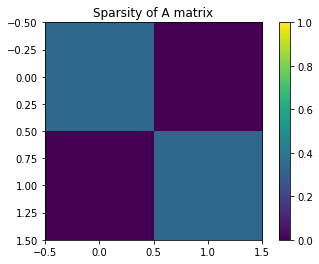

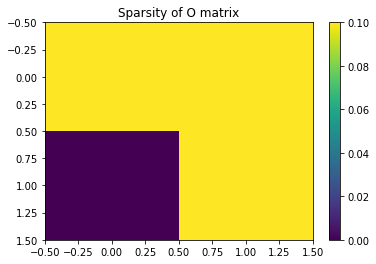

In [18]:
visualize_sparsities(test_unsuper_hmm)

In [23]:
X = np.array([[0,1,0], [1,1,1], [0,0,1]])

Y = np.array([[3,1,0], [1,2,1], [1,0,1]])
n_states = 2
N_iters = 100

test_super_hmm = supervised_HMM(X, Y)

test_super_hmm.generate_emission(10)

([1, 0, 1, 0, 0, 0, 1, 1, 1, 1], [1, 0, 1, 0, 1, 0, 1, 2, 1, 2])